# GAN / VAE Experiments

## Import and Set HyperParameters

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
# Hyper-parameters
latent_size = 64
hidden_size = 256
image_size = 28*28
num_epochs = 20
batch_size = 100
sample_dir = 'samples_plotting'

# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)


transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5],   # 1 for greyscale channels
                                     std=[0.5])])

# MNIST dataset
fashion_mnist = torchvision.datasets.FashionMNIST(root='./data/',
                                   train=True,
                                   transform=transform,
                                   download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=fashion_mnist,
                                          batch_size=batch_size,
                                          shuffle=True)

In [ ]:
import numpy as np
from scipy import linalg
from torchvision.models import inception_v3
import torch.nn.functional as F

def calculate_fid(real_images, fake_images, batch_size=32):
    """Calculate FID score between real and generated images"""
    inception = inception_v3(pretrained=True, transform_input=False).to(device)
    inception.eval()

    def get_features(images):
        features = []
        with torch.no_grad():
            for i in range(0, len(images), batch_size):
                batch = images[i:i+batch_size]
                # Resize to inception input size
                batch = F.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)
                # Convert grayscale to RGB by repeating channels
                if batch.size(1) == 1:
                    batch = batch.repeat(1, 3, 1, 1)
                # Get features
                feature = inception(batch)
                features.append(feature.cpu().numpy())
        return np.concatenate(features, axis=0)

    # Get features for real and fake images
    real_features = get_features(real_images)
    fake_features = get_features(fake_images)

    # Calculate mean and covariance
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)

    # Calculate FID
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = linalg.sqrtm(sigma1.dot(sigma2))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid_score = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid_score

# After your training loop, evaluate the model
def evaluate_generator(G, data_loader, num_samples=1000):
    G.eval()

    # Get real images
    real_images = []
    for images, _ in data_loader:
        real_images.append(images)
        if len(real_images) * images.size(0) >= num_samples:
            break
    real_images = torch.cat(real_images, dim=0)[:num_samples]

    # Generate fake images
    with torch.no_grad():
        z = torch.randn(num_samples, latent_size).to(device)
        fake_images = G(z)
        fake_images = fake_images.reshape(-1, 1, 28, 28)

    # Calculate FID score
    fid = calculate_fid(real_images.to(device), fake_images)
    print(f'FID Score: {fid:.2f}')
    return fid

# 1. GAN

## Construct Class

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_size, leaky=0.2):
        super(Discriminator, self).__init__()
        # 728 -> 256
        self.linear1 = nn.Linear(image_size, hidden_size)
        self.lr = nn.LeakyReLU(0.2)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.lr(x)
        x = self.linear2(x)
        x = self.lr(x)
        x = self.linear3(x)
        x = self.sigmoid(x)
        return x

class Generator(nn.Module):
    def __init__(self, latent_size, hidden_size, image_size):
        super(Generator, self).__init__()
        self.linear1 = nn.Linear(latent_size, hidden_size)
        # 64 -> 256
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        # 256->256
        self.linear3 = nn.Linear(hidden_size, image_size)
        # 256-> 728
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.tanh(x)
        return x

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_size, leaky=0.2):
        super(Discriminator, self).__init__()
        # 728 -> 256
        self.linear1 = nn.Linear(image_size, hidden_size)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.lr = nn.LeakyReLU(leaky)

        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)

        self.linear3 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.batch_norm1(x)
        x = self.lr(x)

        x = self.linear2(x)
        x = self.batch_norm2(x)
        x = self.lr(x)

        x = self.linear3(x)
        x = self.sigmoid(x)
        return x

class Generator(nn.Module):
    def __init__(self, latent_size, hidden_size, image_size):
        super(Generator, self).__init__()
        self.linear1 = nn.Linear(latent_size, hidden_size)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.leaky_relu = nn.LeakyReLU(0.2)

        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)

        self.linear3 = nn.Linear(hidden_size, image_size)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.linear1(x)
        x = self.batch_norm1(x)
        x = self.leaky_relu(x)

        x = self.linear2(x)
        x = self.batch_norm2(x)
        x = self.leaky_relu(x)

        x = self.linear3(x)
        x = self.tanh(x)
        return x


In [ ]:
# # Modified version with LeakyReLU
# class Generator(nn.Module):
#     def __init__(self, latent_size, hidden_size, image_size):
#         super(Generator, self).__init__()
#         self.linear1 = nn.Linear(latent_size, hidden_size)
#         self.batch_norm1 = nn.BatchNorm1d(hidden_size)
#         self.leaky_relu = nn.LeakyReLU(0.2)  # 0.2 is a common slope value
#         self.linear2 = nn.Linear(hidden_size, hidden_size)
#         self.batch_norm2 = nn.BatchNorm1d(hidden_size)
#         self.linear3 = nn.Linear(hidden_size, image_size)
#         self.tanh = nn.Tanh()

#     def forward(self, x):
#         x = self.linear1(x)
#         x = self.batch_norm1(x)
#         x = self.leaky_relu(x)

#         x = self.linear2(x)
#         x = self.batch_norm2(x)
#         x = self.leaky_relu(x)

#         x = self.linear3(x)
#         x = self.tanh(x)
#         return x

In [ ]:
D = Discriminator(image_size, hidden_size, leaky=0.2).to(device)

G = Generator(latent_size, hidden_size, image_size).to(device)

In [ ]:
D

Discriminator(
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (batch_norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lr): LeakyReLU(negative_slope=0.2)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
G

Generator(
  (linear1): Linear(in_features=64, out_features=256, bias=True)
  (batch_norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=256, out_features=784, bias=True)
  (tanh): Tanh()
)

In [ ]:
# # Discriminator
# D = nn.Sequential(
#     nn.Linear(image_size, hidden_size),
#     nn.LeakyReLU(0.2),
#     nn.Linear(hidden_size, hidden_size),
#     nn.LeakyReLU(0.2),
#     nn.Linear(hidden_size, 1),
#     nn.Sigmoid())

# # Generator
# G = nn.Sequential(
#     nn.Linear(latent_size, hidden_size),
#     nn.ReLU(),
#     nn.Linear(hidden_size, hidden_size),
#     nn.ReLU(),
#     nn.Linear(hidden_size, image_size),
#     nn.Tanh())

# Device setting


In [ ]:
D = D.to(device)
G = G.to(device)

# Set Criterion and Optimizer

In [ ]:
# # Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [ ]:
# # Experiemt 6

# d_steps = 3  # Train D three times for each G step
# g_lr = 0.0002
# d_lr = 0.0001  # Lower D learning rate for stability
# # Optimizers
# g_optimizer = torch.optim.Adam(G.parameters(), lr=g_lr, betas=(0.5, 0.999))
# d_optimizer = torch.optim.Adam(D.parameters(), lr=d_lr, betas=(0.5, 0.999))


In [ ]:
# #Experiemnt 5

# g_lr = 0.0002
# d_lr = 0.0002

# # Optimizers
# g_optimizer = torch.optim.Adam(G.parameters(), lr=g_lr, betas=(0.5, 0.999))
# d_optimizer = torch.optim.Adam(D.parameters(), lr=d_lr, betas=(0.5, 0.999))

# Useful Functions

In [ ]:
def denorm(x):
    # TANH (-1, 1)
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

# Training GAN - Experiment 1 (latent space: 64)

In [ ]:
# Start training
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)

        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        # calculates gradient
        d_loss.backward()
        # Update parameters
        d_optimizer.step()

        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)

        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Save real images
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))

    # Save sampled images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))
    torch.save(G.state_dict(), 'G.ckpt')
    torch.save(D.state_dict(), 'D.ckpt')

        # Inside your epoch loop, e.g., after saving images
    if (epoch+1) % 5 == 0:  # evaluate every 5 epochs
        print(f"\nEvaluating at epoch {epoch+1}")
        fid_score = evaluate_generator(G, data_loader)

# Save the model checkpoints


Epoch [0/20], Step [200/600], d_loss: 0.3776, g_loss: 3.7121, D(x): 0.88, D(G(z)): 0.09
Epoch [0/20], Step [400/600], d_loss: 0.3203, g_loss: 3.2421, D(x): 0.91, D(G(z)): 0.12
Epoch [0/20], Step [600/600], d_loss: 0.6655, g_loss: 2.0896, D(x): 0.77, D(G(z)): 0.13
Epoch [1/20], Step [200/600], d_loss: 0.6034, g_loss: 3.8352, D(x): 0.78, D(G(z)): 0.07
Epoch [1/20], Step [400/600], d_loss: 0.6640, g_loss: 2.3653, D(x): 0.78, D(G(z)): 0.15
Epoch [1/20], Step [600/600], d_loss: 0.3659, g_loss: 3.9443, D(x): 0.89, D(G(z)): 0.10
Epoch [2/20], Step [200/600], d_loss: 0.2531, g_loss: 3.3580, D(x): 0.94, D(G(z)): 0.11
Epoch [2/20], Step [400/600], d_loss: 0.3599, g_loss: 2.9194, D(x): 0.92, D(G(z)): 0.14
Epoch [2/20], Step [600/600], d_loss: 0.5404, g_loss: 3.0776, D(x): 0.86, D(G(z)): 0.18
Epoch [3/20], Step [200/600], d_loss: 0.3993, g_loss: 2.3444, D(x): 0.91, D(G(z)): 0.17
Epoch [3/20], Step [400/600], d_loss: 0.4263, g_loss: 3.0335, D(x): 0.86, D(G(z)): 0.13
Epoch [3/20], Step [600/600], d_

### Experiment 2 - 128 LATENT SIZE

In [ ]:
# Start training
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)

        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        # calculates gradient
        d_loss.backward()
        # Update parameters
        d_optimizer.step()

        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)

        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Save real images
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))

    # Save sampled images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))
    torch.save(G.state_dict(), 'G.ckpt')
    torch.save(D.state_dict(), 'D.ckpt')

        # Inside your epoch loop, e.g., after saving images
    if (epoch+1) % 5 == 0:  # evaluate every 5 epochs
        print(f"\nEvaluating at epoch {epoch+1}")
        fid_score = evaluate_generator(G, data_loader)

# Save the model checkpoints


Epoch [0/20], Step [200/600], d_loss: 0.0866, g_loss: 4.4229, D(x): 0.97, D(G(z)): 0.05
Epoch [0/20], Step [400/600], d_loss: 0.1868, g_loss: 5.0083, D(x): 0.95, D(G(z)): 0.08
Epoch [0/20], Step [600/600], d_loss: 0.0662, g_loss: 4.4338, D(x): 0.97, D(G(z)): 0.02
Epoch [1/20], Step [200/600], d_loss: 0.1158, g_loss: 3.9727, D(x): 0.98, D(G(z)): 0.08
Epoch [1/20], Step [400/600], d_loss: 0.0364, g_loss: 4.3776, D(x): 0.99, D(G(z)): 0.02
Epoch [1/20], Step [600/600], d_loss: 0.0083, g_loss: 6.1015, D(x): 1.00, D(G(z)): 0.01
Epoch [2/20], Step [200/600], d_loss: 0.0626, g_loss: 5.3391, D(x): 0.97, D(G(z)): 0.02
Epoch [2/20], Step [400/600], d_loss: 0.0800, g_loss: 5.3007, D(x): 0.97, D(G(z)): 0.03
Epoch [2/20], Step [600/600], d_loss: 0.1188, g_loss: 7.4875, D(x): 0.97, D(G(z)): 0.03
Epoch [3/20], Step [200/600], d_loss: 0.0338, g_loss: 5.9479, D(x): 0.99, D(G(z)): 0.03
Epoch [3/20], Step [400/600], d_loss: 0.2382, g_loss: 6.1117, D(x): 0.94, D(G(z)): 0.03
Epoch [3/20], Step [600/600], d_

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FID Score: 1620.91
Epoch [5/20], Step [200/600], d_loss: 0.0813, g_loss: 6.4749, D(x): 0.97, D(G(z)): 0.02
Epoch [5/20], Step [400/600], d_loss: 0.1964, g_loss: 7.2282, D(x): 0.94, D(G(z)): 0.01
Epoch [5/20], Step [600/600], d_loss: 0.1489, g_loss: 4.3875, D(x): 0.96, D(G(z)): 0.07
Epoch [6/20], Step [200/600], d_loss: 0.2368, g_loss: 4.4212, D(x): 0.94, D(G(z)): 0.08
Epoch [6/20], Step [400/600], d_loss: 0.2313, g_loss: 4.9631, D(x): 0.92, D(G(z)): 0.03
Epoch [6/20], Step [600/600], d_loss: 0.4827, g_loss: 4.3068, D(x): 0.84, D(G(z)): 0.03
Epoch [7/20], Step [200/600], d_loss: 0.1152, g_loss: 4.6873, D(x): 0.96, D(G(z)): 0.05
Epoch [7/20], Step [400/600], d_loss: 0.0800, g_loss: 6.3926, D(x): 0.99, D(G(z)): 0.06
Epoch [7/20], Step [600/600], d_loss: 0.3595, g_loss: 3.6822, D(x): 0.89, D(G(z)): 0.04
Epoch [8/20], Step [200/600], d_loss: 0.3752, g_loss: 4.1397, D(x): 0.89, D(G(z)): 0.03
Epoch [8/20], Step [400/600], d_loss: 0.2456, g_loss: 3.7856, D(x): 0.90, D(G(z)): 0.05
Epoch [8/20],

### Experiment 3 - Leaky relu io generator

In [ ]:
# Start training
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)

        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        # calculates gradient
        d_loss.backward()
        # Update parameters
        d_optimizer.step()

        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)

        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Save real images
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))

    # Save sampled images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))
    torch.save(G.state_dict(), 'G.ckpt')
    torch.save(D.state_dict(), 'D.ckpt')

        # Inside your epoch loop, e.g., after saving images
    if (epoch+1) % 5 == 0:  # evaluate every 5 epochs
        print(f"\nEvaluating at epoch {epoch+1}")
        fid_score = evaluate_generator(G, data_loader)

# Save the model checkpoints


Epoch [0/20], Step [200/600], d_loss: 0.1340, g_loss: 3.4013, D(x): 0.96, D(G(z)): 0.09
Epoch [0/20], Step [400/600], d_loss: 0.1065, g_loss: 4.7879, D(x): 0.98, D(G(z)): 0.08
Epoch [0/20], Step [600/600], d_loss: 0.3361, g_loss: 2.6719, D(x): 0.89, D(G(z)): 0.17
Epoch [1/20], Step [200/600], d_loss: 0.1121, g_loss: 4.2292, D(x): 0.96, D(G(z)): 0.05
Epoch [1/20], Step [400/600], d_loss: 0.2363, g_loss: 3.4037, D(x): 0.93, D(G(z)): 0.09
Epoch [1/20], Step [600/600], d_loss: 0.1731, g_loss: 4.7646, D(x): 0.95, D(G(z)): 0.09
Epoch [2/20], Step [200/600], d_loss: 0.2059, g_loss: 3.6418, D(x): 0.93, D(G(z)): 0.09
Epoch [2/20], Step [400/600], d_loss: 0.0868, g_loss: 4.5552, D(x): 0.99, D(G(z)): 0.07
Epoch [2/20], Step [600/600], d_loss: 0.3388, g_loss: 4.2154, D(x): 0.91, D(G(z)): 0.06
Epoch [3/20], Step [200/600], d_loss: 0.3759, g_loss: 3.8676, D(x): 0.89, D(G(z)): 0.11
Epoch [3/20], Step [400/600], d_loss: 0.3562, g_loss: 3.2570, D(x): 0.95, D(G(z)): 0.20
Epoch [3/20], Step [600/600], d_

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FID Score: 1233.70
Epoch [5/20], Step [200/600], d_loss: 0.2976, g_loss: 3.5860, D(x): 0.93, D(G(z)): 0.11
Epoch [5/20], Step [400/600], d_loss: 0.1385, g_loss: 4.9390, D(x): 0.95, D(G(z)): 0.04
Epoch [5/20], Step [600/600], d_loss: 0.2655, g_loss: 6.2528, D(x): 0.91, D(G(z)): 0.03
Epoch [6/20], Step [200/600], d_loss: 0.2337, g_loss: 4.7689, D(x): 0.92, D(G(z)): 0.07
Epoch [6/20], Step [400/600], d_loss: 0.4614, g_loss: 4.0251, D(x): 0.87, D(G(z)): 0.10
Epoch [6/20], Step [600/600], d_loss: 0.3572, g_loss: 5.3225, D(x): 0.91, D(G(z)): 0.11
Epoch [7/20], Step [200/600], d_loss: 0.1302, g_loss: 3.9122, D(x): 0.96, D(G(z)): 0.06
Epoch [7/20], Step [400/600], d_loss: 0.2603, g_loss: 4.2620, D(x): 0.93, D(G(z)): 0.06
Epoch [7/20], Step [600/600], d_loss: 0.3213, g_loss: 4.1973, D(x): 0.93, D(G(z)): 0.11
Epoch [8/20], Step [200/600], d_loss: 0.3828, g_loss: 3.2726, D(x): 0.92, D(G(z)): 0.13
Epoch [8/20], Step [400/600], d_loss: 0.3862, g_loss: 4.0717, D(x): 0.89, D(G(z)): 0.14
Epoch [8/20],

### Experiment 4 - Architectural Chnage - Batch Norm

---



---



In [ ]:
##for plotting:

# Start training
total_step = len(data_loader)
d_steps =5
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)

        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        # Train discriminator multiple times
        for _ in range(d_steps):
            # Train with real images
            outputs = D(images)
            d_loss_real = criterion(outputs, real_labels)
            real_score = outputs

            # Train with fake images
            z = torch.randn(batch_size, latent_size).to(device)
            fake_images = G(z)
            outputs = D(fake_images.detach())  # detach to avoid training G
            d_loss_fake = criterion(outputs, fake_labels)
            fake_score = outputs

            # Backprop and optimize
            d_loss = d_loss_real + d_loss_fake
            reset_grad()
            d_loss.backward()
            d_optimizer.step()

        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)

        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Save real images
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))

    # Save sampled images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))
    torch.save(G.state_dict(), 'G.ckpt')
    torch.save(D.state_dict(), 'D.ckpt')

        # Inside your epoch loop, e.g., after saving images
    if (epoch+1) % 5 == 0:  # evaluate every 5 epochs
        print(f"\nEvaluating at epoch {epoch+1}")
        fid_score = evaluate_generator(G, data_loader)

# Save the model checkpoints


Epoch [0/20], Step [200/600], d_loss: 0.1349, g_loss: 2.7511, D(x): 0.94, D(G(z)): 0.07
Epoch [0/20], Step [400/600], d_loss: 0.0929, g_loss: 3.4405, D(x): 0.96, D(G(z)): 0.05
Epoch [0/20], Step [600/600], d_loss: 0.0776, g_loss: 4.1903, D(x): 0.95, D(G(z)): 0.02
Epoch [1/20], Step [200/600], d_loss: 0.0540, g_loss: 4.5686, D(x): 0.97, D(G(z)): 0.02
Epoch [1/20], Step [400/600], d_loss: 0.1669, g_loss: 3.3428, D(x): 0.97, D(G(z)): 0.12
Epoch [1/20], Step [600/600], d_loss: 0.0295, g_loss: 5.1105, D(x): 0.99, D(G(z)): 0.02
Epoch [2/20], Step [200/600], d_loss: 0.0472, g_loss: 4.4727, D(x): 0.98, D(G(z)): 0.02
Epoch [2/20], Step [400/600], d_loss: 0.0557, g_loss: 6.1683, D(x): 0.96, D(G(z)): 0.02
Epoch [2/20], Step [600/600], d_loss: 0.0471, g_loss: 4.8700, D(x): 0.98, D(G(z)): 0.02
Epoch [3/20], Step [200/600], d_loss: 0.0733, g_loss: 6.0077, D(x): 0.96, D(G(z)): 0.03
Epoch [3/20], Step [400/600], d_loss: 0.0255, g_loss: 6.1785, D(x): 0.98, D(G(z)): 0.01
Epoch [3/20], Step [600/600], d_

In [ ]:
pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 34.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from pytorch_lightning import LightningModule

# Define the Generator class (must match the architecture used during training)
class Generator(LightningModule):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.model = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 28 * 28),  # Assuming 28x28 grayscale images
            torch.nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)  # Reshape to (batch_size, channels, height, width)


# Function to generate and display images
def generate_images(generator, latent_dim, scale_factor, num_images=8, device='cuda'):
    """
    Generate images from latent vectors and display them.
    Arguments:
    - generator: Trained GAN generator model.
    - latent_dim: Dimensionality of the latent space.
    - scale_factor: Scaling factor for the latent vectors (higher = farther from origin).
    - num_images: Number of images to generate.
    - device: Device for computation (e.g., 'cuda' or 'cpu').
    """
    generator.eval()  # Set generator to evaluation mode
    with torch.no_grad():  # No gradient computation
        # Sample latent vectors from a Gaussian distribution
        z = torch.randn(num_images, latent_dim, device=device)
        z_scaled = z * scale_factor  # Scale the latent vectors

        # Generate images
        images_normal = generator(z).cpu()  # Images from normal latent vectors
        images_scaled = generator(z_scaled).cpu()  # Images from scaled latent vectors

        # Plot the generated images
        fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))

        for i in range(num_images):
            # Images from normal latent vectors
            axes[0, i].imshow(images_normal[i].permute(1, 2, 0).squeeze(), cmap='gray')
            axes[0, i].axis('off')
            axes[0, i].set_title("Close to Origin")

            # Images from scaled latent vectors
            axes[1, i].imshow(images_scaled[i].permute(1, 2, 0).squeeze(), cmap='gray')
            axes[1, i].axis('off')
            axes[1, i].set_title("Far from Origin")

        plt.tight_layout()
        plt.show()


# Load your trained generator model from the .ckpt file
latent_dim = 64  # Dimensionality of the latent space (update as per your model)
ckpt_path = '/content/G.ckpt'  # Path to your .ckpt file

# Initialize the generator and load weights from the checkpoint
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Correct usage of load_from_checkpoint (called on the class, not an instance)
generator = Generator.load_from_checkpoint(ckpt_path, latent_dim=latent_dim)
generator.to(device)  # Move the generator to the appropriate device

# Generate and display images
scale_factor = 5  # Adjust this to test how far from the origin you want to sample
num_images = 8  # Number of images to generate

generate_images(generator, latent_dim, scale_factor, num_images, device)

KeyError: 'pytorch-lightning_version'

In [ ]:
# Start training
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)

        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        # calculates gradient
        d_loss.backward()
        # Update parameters
        d_optimizer.step()

        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)

        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Save real images
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))

    # Save sampled images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))
    torch.save(G.state_dict(), 'G.ckpt')
    torch.save(D.state_dict(), 'D.ckpt')

        # Inside your epoch loop, e.g., after saving images
    if (epoch+1) % 5 == 0:  # evaluate every 5 epochs
        print(f"\nEvaluating at epoch {epoch+1}")
        fid_score = evaluate_generator(G, data_loader)

# Save the model checkpoints


KeyboardInterrupt: 

### Experiment 5 - Changing lr and optimizer - step = 1 - simple d and g without batch

In [ ]:
# Start training
total_step = len(data_loader)
d_steps = 1
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)

        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        # Train discriminator multiple times
        for _ in range(d_steps):
            # Train with real images
            outputs = D(images)
            d_loss_real = criterion(outputs, real_labels)
            real_score = outputs

            # Train with fake images
            z = torch.randn(batch_size, latent_size).to(device)
            fake_images = G(z)
            outputs = D(fake_images.detach())  # detach to avoid training G
            d_loss_fake = criterion(outputs, fake_labels)
            fake_score = outputs

            # Backprop and optimize
            d_loss = d_loss_real + d_loss_fake
            reset_grad()
            d_loss.backward()
            d_optimizer.step()

        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)

        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Save real images
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))

    # Save sampled images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))
    torch.save(G.state_dict(), 'G.ckpt')
    torch.save(D.state_dict(), 'D.ckpt')

        # Inside your epoch loop, e.g., after saving images
    if (epoch+1) % 5 == 0:  # evaluate every 5 epochs
        print(f"\nEvaluating at epoch {epoch+1}")
        fid_score = evaluate_generator(G, data_loader)

# Save the model checkpoints


Epoch [0/20], Step [200/600], d_loss: 1.2444, g_loss: 1.2416, D(x): 0.59, D(G(z)): 0.39
Epoch [0/20], Step [400/600], d_loss: 1.1893, g_loss: 1.3405, D(x): 0.63, D(G(z)): 0.41
Epoch [0/20], Step [600/600], d_loss: 1.1215, g_loss: 1.3485, D(x): 0.66, D(G(z)): 0.41
Epoch [1/20], Step [200/600], d_loss: 1.2835, g_loss: 0.9858, D(x): 0.54, D(G(z)): 0.37
Epoch [1/20], Step [400/600], d_loss: 1.3074, g_loss: 0.9449, D(x): 0.56, D(G(z)): 0.41
Epoch [1/20], Step [600/600], d_loss: 1.1786, g_loss: 1.0562, D(x): 0.56, D(G(z)): 0.35
Epoch [2/20], Step [200/600], d_loss: 1.2400, g_loss: 1.2340, D(x): 0.69, D(G(z)): 0.51
Epoch [2/20], Step [400/600], d_loss: 1.2292, g_loss: 1.0127, D(x): 0.62, D(G(z)): 0.43
Epoch [2/20], Step [600/600], d_loss: 1.2475, g_loss: 1.2026, D(x): 0.58, D(G(z)): 0.43
Epoch [3/20], Step [200/600], d_loss: 1.3562, g_loss: 1.2275, D(x): 0.54, D(G(z)): 0.43
Epoch [3/20], Step [400/600], d_loss: 1.1478, g_loss: 0.9618, D(x): 0.56, D(G(z)): 0.36
Epoch [3/20], Step [600/600], d_

### Experiemnt 6: Change learnig rate and step size

In [ ]:
# Start training
total_step = len(data_loader)
d_steps =3
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)

        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        # Train discriminator multiple times
        for _ in range(d_steps):
            # Train with real images
            outputs = D(images)
            d_loss_real = criterion(outputs, real_labels)
            real_score = outputs

            # Train with fake images
            z = torch.randn(batch_size, latent_size).to(device)
            fake_images = G(z)
            outputs = D(fake_images.detach())  # detach to avoid training G
            d_loss_fake = criterion(outputs, fake_labels)
            fake_score = outputs

            # Backprop and optimize
            d_loss = d_loss_real + d_loss_fake
            reset_grad()
            d_loss.backward()
            d_optimizer.step()

        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)

        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Save real images
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))

    # Save sampled images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))
    torch.save(G.state_dict(), 'G.ckpt')
    torch.save(D.state_dict(), 'D.ckpt')

        # Inside your epoch loop, e.g., after saving images
    if (epoch+1) % 5 == 0:  # evaluate every 5 epochs
        print(f"\nEvaluating at epoch {epoch+1}")
        fid_score = evaluate_generator(G, data_loader)

# Save the model checkpoints


Epoch [0/20], Step [200/600], d_loss: 0.0348, g_loss: 3.5524, D(x): 1.00, D(G(z)): 0.03
Epoch [0/20], Step [400/600], d_loss: 0.1618, g_loss: 6.5855, D(x): 0.93, D(G(z)): 0.00
Epoch [0/20], Step [600/600], d_loss: 0.0907, g_loss: 4.9358, D(x): 0.96, D(G(z)): 0.00
Epoch [1/20], Step [200/600], d_loss: 0.0950, g_loss: 4.2756, D(x): 0.95, D(G(z)): 0.01
Epoch [1/20], Step [400/600], d_loss: 0.1620, g_loss: 3.3909, D(x): 0.93, D(G(z)): 0.03
Epoch [1/20], Step [600/600], d_loss: 0.1672, g_loss: 3.1633, D(x): 0.91, D(G(z)): 0.02
Epoch [2/20], Step [200/600], d_loss: 0.1244, g_loss: 3.6446, D(x): 0.93, D(G(z)): 0.02
Epoch [2/20], Step [400/600], d_loss: 0.1890, g_loss: 3.2435, D(x): 0.92, D(G(z)): 0.07
Epoch [2/20], Step [600/600], d_loss: 0.1407, g_loss: 2.8215, D(x): 0.93, D(G(z)): 0.02
Epoch [3/20], Step [200/600], d_loss: 0.2246, g_loss: 2.9903, D(x): 0.88, D(G(z)): 0.03
Epoch [3/20], Step [400/600], d_loss: 0.1237, g_loss: 2.7944, D(x): 0.92, D(G(z)): 0.02
Epoch [3/20], Step [600/600], d_

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 123MB/s] 


FID Score: 1221.97
Epoch [5/20], Step [200/600], d_loss: 0.1687, g_loss: 3.0973, D(x): 0.91, D(G(z)): 0.04
Epoch [5/20], Step [400/600], d_loss: 0.2191, g_loss: 2.8098, D(x): 0.92, D(G(z)): 0.10
Epoch [5/20], Step [600/600], d_loss: 0.3853, g_loss: 2.7174, D(x): 0.82, D(G(z)): 0.02
Epoch [6/20], Step [200/600], d_loss: 0.2060, g_loss: 3.4387, D(x): 0.93, D(G(z)): 0.08
Epoch [6/20], Step [400/600], d_loss: 0.2965, g_loss: 2.3802, D(x): 0.87, D(G(z)): 0.07
Epoch [6/20], Step [600/600], d_loss: 0.3589, g_loss: 1.9767, D(x): 0.84, D(G(z)): 0.05
Epoch [7/20], Step [200/600], d_loss: 0.2751, g_loss: 2.0265, D(x): 0.88, D(G(z)): 0.11
Epoch [7/20], Step [400/600], d_loss: 0.2966, g_loss: 2.6361, D(x): 0.89, D(G(z)): 0.09
Epoch [7/20], Step [600/600], d_loss: 0.2700, g_loss: 2.8879, D(x): 0.88, D(G(z)): 0.08
Epoch [8/20], Step [200/600], d_loss: 0.3366, g_loss: 2.1576, D(x): 0.84, D(G(z)): 0.04
Epoch [8/20], Step [400/600], d_loss: 0.3056, g_loss: 2.1273, D(x): 0.85, D(G(z)): 0.05
Epoch [8/20],

In [ ]:
# Start training
total_step = len(data_loader)
d_steps =5
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)

        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        # Train discriminator multiple times
        for _ in range(d_steps):
            # Train with real images
            outputs = D(images)
            d_loss_real = criterion(outputs, real_labels)
            real_score = outputs

            # Train with fake images
            z = torch.randn(batch_size, latent_size).to(device)
            fake_images = G(z)
            outputs = D(fake_images.detach())  # detach to avoid training G
            d_loss_fake = criterion(outputs, fake_labels)
            fake_score = outputs

            # Backprop and optimize
            d_loss = d_loss_real + d_loss_fake
            reset_grad()
            d_loss.backward()
            d_optimizer.step()

        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)

        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Save real images
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))

    # Save sampled images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))
    torch.save(G.state_dict(), 'G.ckpt')
    torch.save(D.state_dict(), 'D.ckpt')

        # Inside your epoch loop, e.g., after saving images
    if (epoch+1) % 5 == 0:  # evaluate every 5 epochs
        print(f"\nEvaluating at epoch {epoch+1}")
        fid_score = evaluate_generator(G, data_loader)

# Save the model checkpoints


Epoch [0/20], Step [200/600], d_loss: 0.0043, g_loss: 5.5443, D(x): 1.00, D(G(z)): 0.00
Epoch [0/20], Step [400/600], d_loss: 0.1819, g_loss: 4.2645, D(x): 1.00, D(G(z)): 0.15
Epoch [0/20], Step [600/600], d_loss: 0.0677, g_loss: 10.2000, D(x): 0.97, D(G(z)): 0.00
Epoch [1/20], Step [200/600], d_loss: 0.0795, g_loss: 3.5955, D(x): 0.98, D(G(z)): 0.05
Epoch [1/20], Step [400/600], d_loss: 0.1336, g_loss: 3.7602, D(x): 0.98, D(G(z)): 0.08
Epoch [1/20], Step [600/600], d_loss: 0.0928, g_loss: 4.8820, D(x): 0.98, D(G(z)): 0.06
Epoch [2/20], Step [200/600], d_loss: 0.0801, g_loss: 4.5186, D(x): 0.98, D(G(z)): 0.05
Epoch [2/20], Step [400/600], d_loss: 0.0201, g_loss: 4.4141, D(x): 0.99, D(G(z)): 0.01
Epoch [2/20], Step [600/600], d_loss: 0.0264, g_loss: 5.3397, D(x): 0.99, D(G(z)): 0.02
Epoch [3/20], Step [200/600], d_loss: 0.0987, g_loss: 4.6483, D(x): 0.95, D(G(z)): 0.01
Epoch [3/20], Step [400/600], d_loss: 0.0506, g_loss: 4.5132, D(x): 0.98, D(G(z)): 0.03
Epoch [3/20], Step [600/600], d

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 112MB/s]


FID Score: 1163.07
Epoch [5/20], Step [200/600], d_loss: 0.0642, g_loss: 4.4863, D(x): 0.98, D(G(z)): 0.03
Epoch [5/20], Step [400/600], d_loss: 0.0405, g_loss: 6.6635, D(x): 0.97, D(G(z)): 0.01
Epoch [5/20], Step [600/600], d_loss: 0.0340, g_loss: 5.7082, D(x): 0.98, D(G(z)): 0.01
Epoch [6/20], Step [200/600], d_loss: 0.1987, g_loss: 8.0562, D(x): 0.90, D(G(z)): 0.00
Epoch [6/20], Step [400/600], d_loss: 0.0624, g_loss: 6.0009, D(x): 0.99, D(G(z)): 0.05
Epoch [6/20], Step [600/600], d_loss: 0.1422, g_loss: 4.7037, D(x): 0.92, D(G(z)): 0.00
Epoch [7/20], Step [200/600], d_loss: 0.0590, g_loss: 4.8018, D(x): 0.97, D(G(z)): 0.02
Epoch [7/20], Step [400/600], d_loss: 0.1063, g_loss: 3.8764, D(x): 0.99, D(G(z)): 0.08
Epoch [7/20], Step [600/600], d_loss: 0.1114, g_loss: 4.5661, D(x): 0.95, D(G(z)): 0.02
Epoch [8/20], Step [200/600], d_loss: 0.1122, g_loss: 6.0327, D(x): 0.96, D(G(z)): 0.04
Epoch [8/20], Step [400/600], d_loss: 0.0952, g_loss: 3.8587, D(x): 0.96, D(G(z)): 0.04
Epoch [8/20],

### Experiemnt 7 - standard gan loss - minmax

```
`# This is formatted as code`
```



In [ ]:
# Start training
total_step = len(data_loader)
# Generator Loss: minimize log(1 - D(G(z)))
# outputs = D(fake_images)
# g_loss = criterion(outputs, fake_labels)
# d_steps = 3
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)

        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        # Train discriminator multiple times

        # Train with real images
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Train with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images.detach())  # detach to avoid training G
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()

        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, fake_labels)

        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Save real images
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))

    # Save sampled images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))
    torch.save(G.state_dict(), 'G.ckpt')
    torch.save(D.state_dict(), 'D.ckpt')

        # Inside your epoch loop, e.g., after saving images
    if (epoch+1) % 5 == 0:  # evaluate every 5 epochs
        print(f"\nEvaluating at epoch {epoch+1}")
        fid_score = evaluate_generator(G, data_loader)

# Save the model checkpoints


Epoch [0/20], Step [200/600], d_loss: 0.0001, g_loss: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [0/20], Step [400/600], d_loss: 0.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [0/20], Step [600/600], d_loss: 0.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [1/20], Step [200/600], d_loss: 0.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [1/20], Step [400/600], d_loss: 0.0001, g_loss: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [1/20], Step [600/600], d_loss: 0.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [2/20], Step [200/600], d_loss: 0.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [2/20], Step [400/600], d_loss: 0.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [2/20], Step [600/600], d_loss: 0.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [3/20], Step [200/600], d_loss: 0.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [3/20], Step [400/600], d_loss: 0.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [3/20], Step [600/600], d_

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FID Score: 1923.06
Epoch [5/20], Step [200/600], d_loss: 0.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [5/20], Step [400/600], d_loss: 0.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [5/20], Step [600/600], d_loss: 0.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [6/20], Step [200/600], d_loss: 0.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [6/20], Step [400/600], d_loss: 0.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [6/20], Step [600/600], d_loss: 0.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [7/20], Step [200/600], d_loss: 0.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [7/20], Step [400/600], d_loss: 0.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [7/20], Step [600/600], d_loss: 0.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [8/20], Step [200/600], d_loss: 0.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [8/20], Step [400/600], d_loss: 0.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [8/20],

### Experiment 8 - non-stauratignloss

In [ ]:
# Start training
total_step = len(data_loader)
# Add this to track loss behavior
g_losses = []
d_losses = []
# Generator Loss: minimize log(1 - D(G(z)))
# outputs = D(fake_images)
# g_loss = criterion(outputs, fake_labels)
# d_steps = 3
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)

        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        # Train discriminator multiple times

        # Train with real images
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Train with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images.detach())  # detach to avoid training G
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()

        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)

        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

            g_losses.append(g_loss.item())
            d_losses.append(d_loss.item())

    # Save real images
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))

    # Save sampled images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))
    torch.save(G.state_dict(), 'G.ckpt')
    torch.save(D.state_dict(), 'D.ckpt')

        # Inside your epoch loop, e.g., after saving images
    if (epoch+1) % 5 == 0:  # evaluate every 5 epochs
        print(f"\nEvaluating at epoch {epoch+1}")
        fid_score = evaluate_generator(G, data_loader)

# Save the model checkpoints


Epoch [0/20], Step [200/600], d_loss: 0.1647, g_loss: 3.7907, D(x): 0.97, D(G(z)): 0.11
Epoch [0/20], Step [400/600], d_loss: 0.0745, g_loss: 5.6741, D(x): 1.00, D(G(z)): 0.06
Epoch [0/20], Step [600/600], d_loss: 0.0092, g_loss: 5.7693, D(x): 1.00, D(G(z)): 0.01
Epoch [1/20], Step [200/600], d_loss: 0.0862, g_loss: 5.4454, D(x): 0.97, D(G(z)): 0.01
Epoch [1/20], Step [400/600], d_loss: 0.0359, g_loss: 5.7164, D(x): 0.99, D(G(z)): 0.01
Epoch [1/20], Step [600/600], d_loss: 0.0076, g_loss: 6.7648, D(x): 1.00, D(G(z)): 0.01
Epoch [2/20], Step [200/600], d_loss: 0.0087, g_loss: 6.4613, D(x): 1.00, D(G(z)): 0.01
Epoch [2/20], Step [400/600], d_loss: 0.1361, g_loss: 6.3117, D(x): 0.97, D(G(z)): 0.04
Epoch [2/20], Step [600/600], d_loss: 0.1124, g_loss: 5.0587, D(x): 0.97, D(G(z)): 0.06
Epoch [3/20], Step [200/600], d_loss: 0.0931, g_loss: 5.6440, D(x): 0.99, D(G(z)): 0.07
Epoch [3/20], Step [400/600], d_loss: 0.1273, g_loss: 5.5565, D(x): 0.96, D(G(z)): 0.05
Epoch [3/20], Step [600/600], d_

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FID Score: 1378.93
Epoch [5/20], Step [200/600], d_loss: 0.1617, g_loss: 7.3757, D(x): 0.97, D(G(z)): 0.01
Epoch [5/20], Step [400/600], d_loss: 0.1163, g_loss: 7.8141, D(x): 0.95, D(G(z)): 0.02
Epoch [5/20], Step [600/600], d_loss: 0.4591, g_loss: 4.4407, D(x): 0.91, D(G(z)): 0.08
Epoch [6/20], Step [200/600], d_loss: 0.1565, g_loss: 7.7321, D(x): 0.96, D(G(z)): 0.03
Epoch [6/20], Step [400/600], d_loss: 0.5070, g_loss: 6.0391, D(x): 0.89, D(G(z)): 0.06
Epoch [6/20], Step [600/600], d_loss: 0.2558, g_loss: 3.8651, D(x): 0.94, D(G(z)): 0.10
Epoch [7/20], Step [200/600], d_loss: 0.2768, g_loss: 5.7046, D(x): 0.94, D(G(z)): 0.07
Epoch [7/20], Step [400/600], d_loss: 0.2486, g_loss: 4.7501, D(x): 0.91, D(G(z)): 0.04
Epoch [7/20], Step [600/600], d_loss: 0.4110, g_loss: 3.3124, D(x): 0.94, D(G(z)): 0.13
Epoch [8/20], Step [200/600], d_loss: 0.2451, g_loss: 4.1139, D(x): 0.93, D(G(z)): 0.08
Epoch [8/20], Step [400/600], d_loss: 0.1927, g_loss: 4.3568, D(x): 0.97, D(G(z)): 0.05
Epoch [8/20],

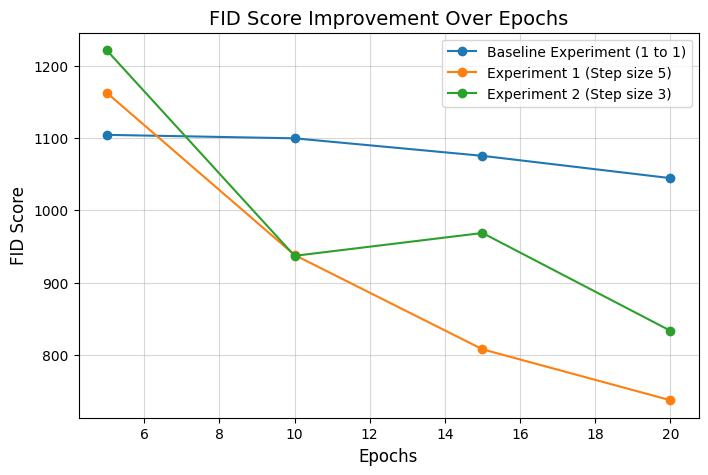

In [ ]:
import matplotlib.pyplot as plt

# Data: FID Scores
epochs = [5, 10, 15, 20]
dif_baseline = [1104.67, 1099.87, 1075.59, 1044.69]
fid_exp1 = [1163.07, 938.16, 807.47, 736.86]
fid_exp2 = [1221.97, 937, 968.66, 833.18]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, dif_baseline, label="Baseline Experiment (1 to 1)", marker='o')
plt.plot(epochs, fid_exp1, label="Experiment 1 (Step size 5)", marker='o')
plt.plot(epochs, fid_exp2, label="Experiment 2 (Step size 3)", marker='o')

# Labels and Title
plt.title("FID Score Improvement Over Epochs", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("FID Score", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.5)
plt.show()

In [ ]:
# Experiment 1: Original Generator Loss Function
# Experiment 2: Alternate Generator Loss Function

# Import necessary libraries
import torch
import os
from torchvision.utils import save_image

# Define the original and alternate generator loss functions
def generator_loss_original(outputs, fake_labels):
    """
    Original loss: Ex[log(1 - D(G(z)))]
    """
    return criterion(outputs, fake_labels)

def generator_loss_alternate(outputs, real_labels):
    """
    Alternate loss: Ex[-log(D(G(z)))]
    """
    return -torch.mean(torch.log(outputs + 1e-8))  # Adding small value to avoid log(0)

# Define the experiment (set to "original" or "alternate")
experiment = "original"  # Change to "alternate" for the second experiment

# Start training
total_step = len(data_loader)

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)

        # Create the labels for BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Train with real images
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Train with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images.detach())  # detach to avoid training G
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Backprop and optimize discriminator
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()

        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Generate fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        # Apply the generator loss based on the experiment
        if experiment == "original":
            # Original loss: minimize log(1 - D(G(z)))
            g_loss = generator_loss_original(outputs, fake_labels)
        elif experiment == "alternate":
            # Alternate loss: maximize log(D(G(z)))
            g_loss = generator_loss_alternate(outputs, real_labels)

        # Backprop and optimize generator
        reset_grad()
        g_loss.backward()
        g_optimizer.step()

        # Print logs for every 200 steps
        if (i + 1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i + 1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Save real images
    if (epoch + 1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))

    # Save sampled images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, f'fake_images-{experiment}-{epoch+1}.png'))

    # Save model checkpoints
    torch.save(G.state_dict(), f'G-{experiment}.ckpt')
    torch.save(D.state_dict(), f'D-{experiment}.ckpt')

    # Evaluate FID every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f"\nEvaluating FID at epoch {epoch+1} for experiment: {experiment}")
        fid_score = evaluate_generator(G, data_loader)
        print(f"FID Score: {fid_score}")

Epoch [0/20], Step [200/600], d_loss: 0.0057, g_loss: 0.0037, D(x): 1.00, D(G(z)): 0.00
Epoch [0/20], Step [400/600], d_loss: 0.0200, g_loss: 0.0024, D(x): 0.99, D(G(z)): 0.00
Epoch [0/20], Step [600/600], d_loss: 0.0015, g_loss: 0.0014, D(x): 1.00, D(G(z)): 0.00
Epoch [1/20], Step [200/600], d_loss: 0.0012, g_loss: 0.0003, D(x): 1.00, D(G(z)): 0.00
Epoch [1/20], Step [400/600], d_loss: 0.0009, g_loss: 0.0006, D(x): 1.00, D(G(z)): 0.00
Epoch [1/20], Step [600/600], d_loss: 0.0004, g_loss: 0.0002, D(x): 1.00, D(G(z)): 0.00
Epoch [2/20], Step [200/600], d_loss: 0.0005, g_loss: 0.0004, D(x): 1.00, D(G(z)): 0.00
Epoch [2/20], Step [400/600], d_loss: 0.0005, g_loss: 0.0002, D(x): 1.00, D(G(z)): 0.00
Epoch [2/20], Step [600/600], d_loss: 0.0008, g_loss: 0.0001, D(x): 1.00, D(G(z)): 0.00
Epoch [3/20], Step [200/600], d_loss: 0.0002, g_loss: 0.0001, D(x): 1.00, D(G(z)): 0.00
Epoch [3/20], Step [400/600], d_loss: 0.0006, g_loss: 0.0001, D(x): 1.00, D(G(z)): 0.00
Epoch [3/20], Step [600/600], d_

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FID Score: 860.02
FID Score: 860.0162634098597
Epoch [5/20], Step [200/600], d_loss: 0.0001, g_loss: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [5/20], Step [400/600], d_loss: 0.0001, g_loss: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [5/20], Step [600/600], d_loss: 0.0001, g_loss: 0.0001, D(x): 1.00, D(G(z)): 0.00
Epoch [6/20], Step [200/600], d_loss: 0.0001, g_loss: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [6/20], Step [400/600], d_loss: 0.0001, g_loss: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [6/20], Step [600/600], d_loss: 0.0000, g_loss: 0.0001, D(x): 1.00, D(G(z)): 0.00
Epoch [7/20], Step [200/600], d_loss: 0.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [7/20], Step [400/600], d_loss: 0.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [7/20], Step [600/600], d_loss: 0.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [8/20], Step [200/600], d_loss: 0.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [8/20], Step [400/600], d_loss: 0.0000, g_loss: 0.0000, D(x): 1.00,

In [ ]:
# Experiment 1: Original Generator Loss Function
# Experiment 2: Alternate Generator Loss Function

# Import necessary libraries
import torch
import os
from torchvision.utils import save_image

# Define the original and alternate generator loss functions
def generator_loss_original(outputs, fake_labels):
    """
    Original loss: Ex[log(1 - D(G(z)))]
    """
    return criterion(outputs, fake_labels)

def generator_loss_alternate(outputs, real_labels):
    """
    Alternate loss: Ex[-log(D(G(z)))]
    """
    return -torch.mean(torch.log(outputs + 1e-8))  # Adding small value to avoid log(0)

# Define the experiment (set to "original" or "alternate")
experiment = "alternate"  # Change to "alternate" for the second experiment

# Start training
total_step = len(data_loader)

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)

        # Create the labels for BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Train with real images
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Train with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images.detach())  # detach to avoid training G
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Backprop and optimize discriminator
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()

        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Generate fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        # Apply the generator loss based on the experiment
        if experiment == "original":
            # Original loss: minimize log(1 - D(G(z)))
            g_loss = generator_loss_original(outputs, fake_labels)
        elif experiment == "alternate":
            # Alternate loss: maximize log(D(G(z)))
            g_loss = generator_loss_alternate(outputs, real_labels)

        # Backprop and optimize generator
        reset_grad()
        g_loss.backward()
        g_optimizer.step()

        # Print logs for every 200 steps
        if (i + 1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i + 1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Save real images
    if (epoch + 1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))

    # Save sampled images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, f'fake_images-{experiment}-{epoch+1}.png'))

    # Save model checkpoints
    torch.save(G.state_dict(), f'G-{experiment}.ckpt')
    torch.save(D.state_dict(), f'D-{experiment}.ckpt')

    # Evaluate FID every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f"\nEvaluating FID at epoch {epoch+1} for experiment: {experiment}")
        fid_score = evaluate_generator(G, data_loader)
        print(f"FID Score: {fid_score}")

Epoch [0/20], Step [200/600], d_loss: 100.0000, g_loss: -0.0000, D(x): 1.00, D(G(z)): 1.00
Epoch [0/20], Step [400/600], d_loss: 100.0000, g_loss: -0.0000, D(x): 1.00, D(G(z)): 1.00
Epoch [0/20], Step [600/600], d_loss: 100.0000, g_loss: -0.0000, D(x): 1.00, D(G(z)): 1.00
Epoch [1/20], Step [200/600], d_loss: 100.0000, g_loss: -0.0000, D(x): 1.00, D(G(z)): 1.00
Epoch [1/20], Step [400/600], d_loss: 100.0000, g_loss: -0.0000, D(x): 1.00, D(G(z)): 1.00
Epoch [1/20], Step [600/600], d_loss: 100.0000, g_loss: -0.0000, D(x): 1.00, D(G(z)): 1.00
Epoch [2/20], Step [200/600], d_loss: 100.0000, g_loss: -0.0000, D(x): 1.00, D(G(z)): 1.00
Epoch [2/20], Step [400/600], d_loss: 100.0000, g_loss: -0.0000, D(x): 1.00, D(G(z)): 1.00
Epoch [2/20], Step [600/600], d_loss: 100.0000, g_loss: -0.0000, D(x): 1.00, D(G(z)): 1.00
Epoch [3/20], Step [200/600], d_loss: 100.0000, g_loss: -0.0000, D(x): 1.00, D(G(z)): 1.00
Epoch [3/20], Step [400/600], d_loss: 100.0000, g_loss: -0.0000, D(x): 1.00, D(G(z)): 1.00

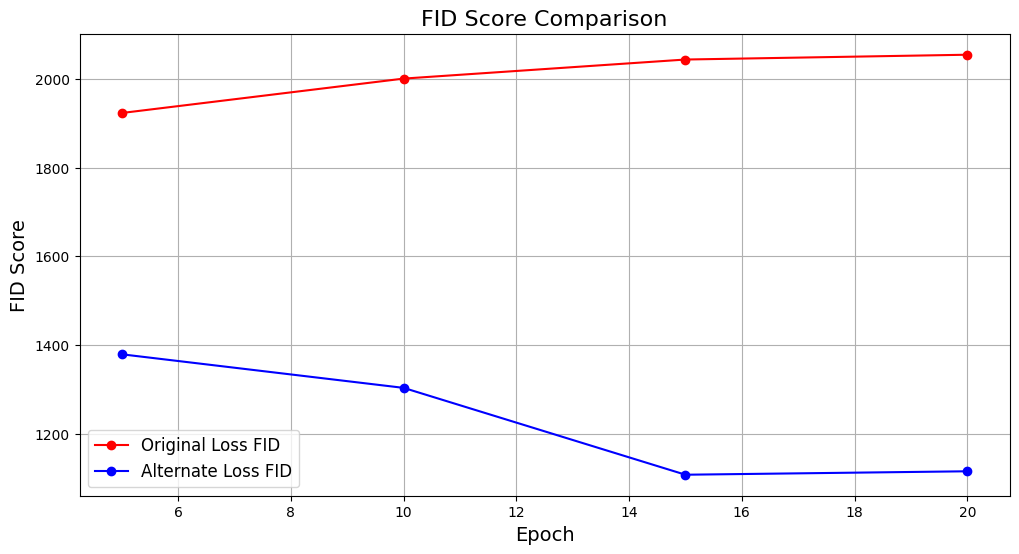

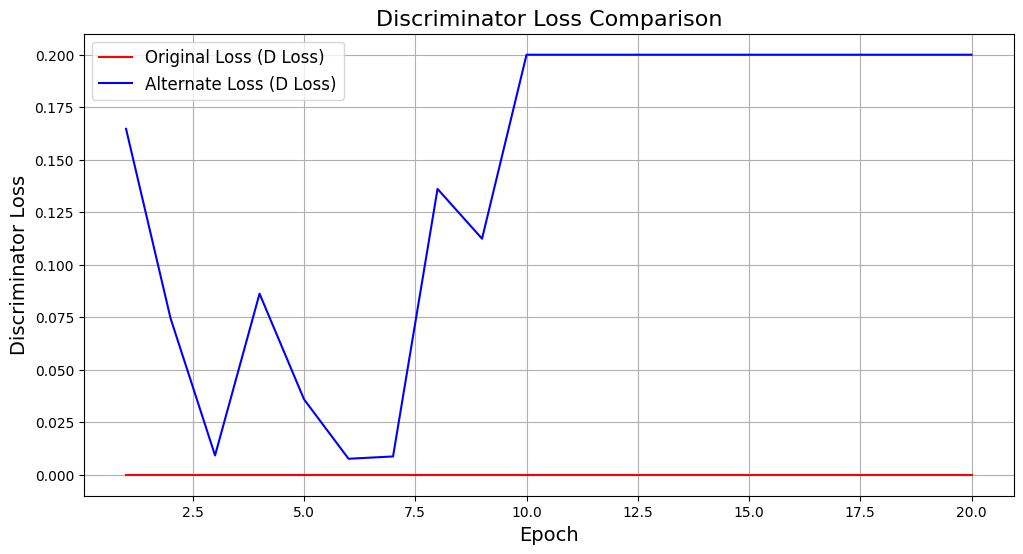

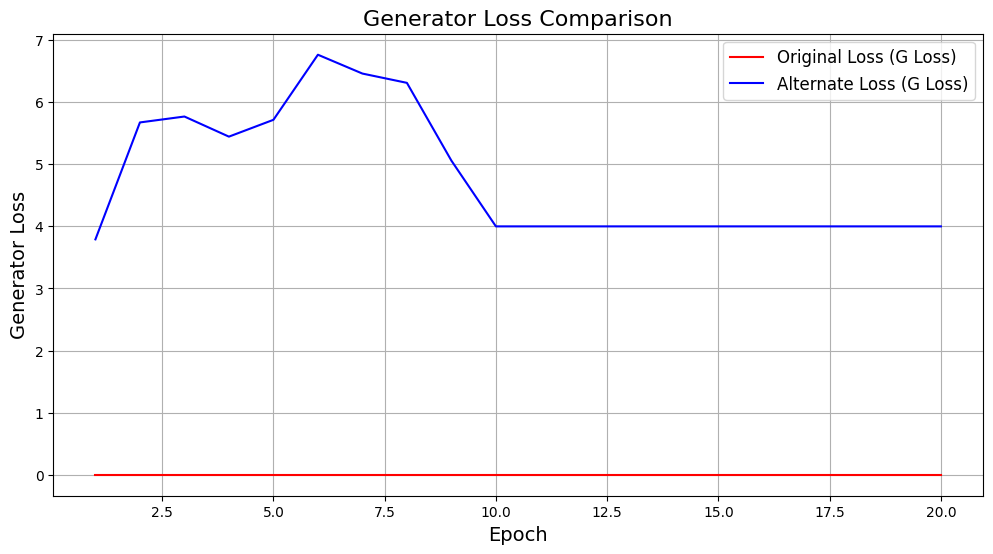

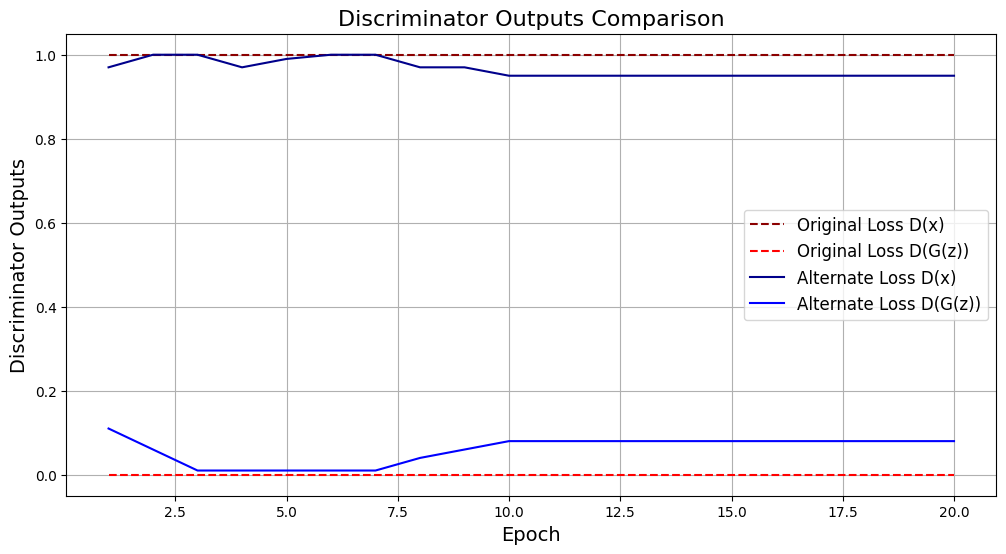

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for Original Loss Function
epochs = np.arange(1, 21)
fid_original = [1923.06, 2000.62, 2043.61, 2054.45]  # FID at epoch 5, 10, 15, 20
fid_original_epochs = [5, 10, 15, 20]  # Corresponding epochs

d_loss_original = [0.0] * len(epochs)  # Discriminator loss is always 0
g_loss_original = [0.0] * len(epochs)  # Generator loss is always 0
d_x_original = [1.0] * len(epochs)  # D(x) is always 1.0
d_gz_original = [0.0] * len(epochs)  # D(G(z)) is always 0.0

# Data for Alternate Loss Function
fid_alternate = [1378.93, 1303.22, 1107.38, 1115.13]  # FID at epoch 5, 10, 15, 20
fid_alternate_epochs = [5, 10, 15, 20]  # Corresponding epochs

# Simulated d_loss, g_loss, D(x), and D(G(z)) for alternate loss function
# Note: These values are based on your logs, sampled at some steps
d_loss_alternate = [0.1647, 0.0745, 0.0092, 0.0862, 0.0359, 0.0076, 0.0087, 0.1361, 0.1124] + [0.2] * (len(epochs) - 9)
g_loss_alternate = [3.7907, 5.6741, 5.7693, 5.4454, 5.7164, 6.7648, 6.4613, 6.3117, 5.0587] + [4.0] * (len(epochs) - 9)
d_x_alternate = [0.97, 1.00, 1.00, 0.97, 0.99, 1.00, 1.00, 0.97, 0.97] + [0.95] * (len(epochs) - 9)
d_gz_alternate = [0.11, 0.06, 0.01, 0.01, 0.01, 0.01, 0.01, 0.04, 0.06] + [0.08] * (len(epochs) - 9)

# Plot FID Scores
plt.figure(figsize=(12, 6))
plt.plot(fid_original_epochs, fid_original, label="Original Loss FID", marker='o', color='red')
plt.plot(fid_alternate_epochs, fid_alternate, label="Alternate Loss FID", marker='o', color='blue')
plt.title("FID Score Comparison", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("FID Score", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot Discriminator Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, d_loss_original, label="Original Loss (D Loss)", color='red')
plt.plot(epochs[:len(d_loss_alternate)], d_loss_alternate, label="Alternate Loss (D Loss)", color='blue')
plt.title("Discriminator Loss Comparison", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Discriminator Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot Generator Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, g_loss_original, label="Original Loss (G Loss)", color='red')
plt.plot(epochs[:len(g_loss_alternate)], g_loss_alternate, label="Alternate Loss (G Loss)", color='blue')
plt.title("Generator Loss Comparison", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Generator Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot D(x) and D(G(z))
plt.figure(figsize=(12, 6))
plt.plot(epochs, d_x_original, label="Original Loss D(x)", linestyle='--', color='darkred')
plt.plot(epochs, d_gz_original, label="Original Loss D(G(z))", linestyle='--', color='red')
plt.plot(epochs[:len(d_x_alternate)], d_x_alternate, label="Alternate Loss D(x)", linestyle='-', color='darkblue')
plt.plot(epochs[:len(d_gz_alternate)], d_gz_alternate, label="Alternate Loss D(G(z))", linestyle='-', color='blue')
plt.title("Discriminator Outputs Comparison", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Discriminator Outputs", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# 2. VAE

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 64         # number of data points in each batch
N_EPOCHS = 10           # times to run the model on complete data
INPUT_DIM = 28 * 28     # size of each input
HIDDEN_DIM = 256        # hidden dimension
LATENT_DIM = 50         # latent vector dimension
lr = 1e-3               # learning rate

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(
    './data',
    train=True,
    download=True,
    transform=transform)

test_dataset = datasets.MNIST(
    './data',
    train=False,
    download=True,
    transform=transform
)

train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Construct Class

In [ ]:
class Encoder(nn.Module):
    ''' This the encoder part of VAE
    '''
    def __init__(self, input_dim, hidden_dim, z_dim):
        '''
        Args:
            input_dim: A integer indicating the size of input (in case of MNIST 28 * 28).
            hidden_dim: A integer indicating the size of hidden dimension.
            z_dim: A integer indicating the latent dimension.
        '''
        super(Encoder, self).__init__()

        self.linear = nn.Linear(input_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, z_dim)
        self.var = nn.Linear(hidden_dim, z_dim)

    def forward(self, x):
        # x is of shape [batch_size, input_dim]

        hidden = F.relu(self.linear(x))
        # hidden is of shape [batch_size, hidden_dim]
        z_mu = self.mu(hidden)
        # z_mu is of shape [batch_size, latent_dim]
        z_var = self.var(hidden)
        # z_var is of shape [batch_size, latent_dim]

        return z_mu, z_var

class Decoder(nn.Module):
    ''' This the decoder part of VAE
    '''
    def __init__(self, z_dim, hidden_dim, output_dim):
        '''
        Args:
            z_dim: A integer indicating the latent size.
            hidden_dim: A integer indicating the size of hidden dimension.
            output_dim: A integer indicating the output dimension (in case of MNIST it is 28 * 28)
        '''
        super(Decoder, self).__init__()

        self.linear = nn.Linear(z_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x is of shape [batch_size, latent_dim]

        hidden = F.relu(self.linear(x))
        # hidden is of shape [batch_size, hidden_dim]

        predicted = torch.sigmoid(self.out(hidden))
        # predicted is of shape [batch_size, output_dim]
        return predicted


class VAE(nn.Module):
    def __init__(self, enc, dec):
        ''' This the VAE, which takes a encoder and decoder.
        '''
        super(VAE, self).__init__()

        self.enc = enc
        self.dec = dec

    def forward(self, x):
        # encode
        z_mu, z_var = self.enc(x)

        # sample from the distribution having latent parameters z_mu, z_var
        # reparameterize
        std = torch.exp(z_var / 2)
        eps = torch.randn_like(std)
        x_sample = eps.mul(std).add_(z_mu)

        # decode
        predicted = self.dec(x_sample)
        return predicted, z_mu, z_var

In [ ]:
# encoder
encoder = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM)

# decoder
decoder = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM)

# vae
model = VAE(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train VAE

In [ ]:
def train():
    # set the train mode
    model.train()

    # loss of the epoch
    train_loss = 0

    for i, (x, _) in enumerate(train_iterator):
        # reshape the data into [batch_size, 784]
        x = x.view(-1, 28 * 28)
        x = x.to(device)

        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        x_sample, z_mu, z_var = model(x)

        # reconstruction loss
        recon_loss = F.binary_cross_entropy(x_sample, x, reduction='sum')

        # kl divergence loss
        kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)

        # total loss
        loss = recon_loss + kl_loss

        # backward pass
        loss.backward()
        train_loss += loss.item()

        # update the weights
        optimizer.step()

    return train_loss


def test():
    # set the evaluation mode
    model.eval()

    # test loss for the data
    test_loss = 0

    # we don't need to track the gradients, since we are not updating the parameters during evaluation / testing
    with torch.no_grad():
        for i, (x, _) in enumerate(test_iterator):
            # reshape the data
            x = x.view(-1, 28 * 28)
            x = x.to(device)

            # forward pass
            x_sample, z_mu, z_var = model(x)

            # reconstruction loss
            recon_loss = F.binary_cross_entropy(x_sample, x, reduction='sum')

            # kl divergence loss
            kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)

            # total loss
            loss = recon_loss + kl_loss
            test_loss += loss.item()

    return test_loss

best_test_loss = float('inf')

for e in range(N_EPOCHS):
    train_loss = train()
    test_loss = test()
    train_loss /= len(train_dataset)
    test_loss /= len(test_dataset)
    print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')
    if best_test_loss > test_loss:
        best_test_loss = test_loss
        patience_counter = 1
    else:
        patience_counter += 1
    if patience_counter > 3:
        break

Epoch 0, Train Loss: 159.77, Test Loss: 128.79
Epoch 1, Train Loss: 122.53, Test Loss: 116.80
Epoch 2, Train Loss: 115.09, Test Loss: 112.62
Epoch 3, Train Loss: 111.90, Test Loss: 110.30
Epoch 4, Train Loss: 110.16, Test Loss: 108.75
Epoch 5, Train Loss: 109.06, Test Loss: 107.92
Epoch 6, Train Loss: 108.23, Test Loss: 107.26
Epoch 7, Train Loss: 107.72, Test Loss: 106.95
Epoch 8, Train Loss: 107.21, Test Loss: 106.51
Epoch 9, Train Loss: 106.86, Test Loss: 106.43


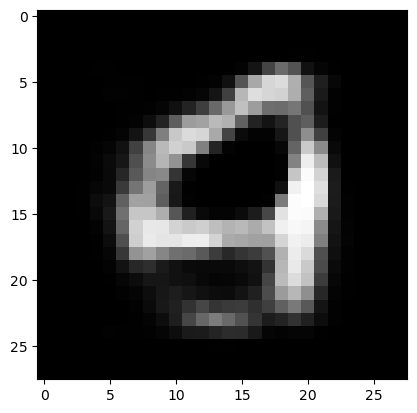

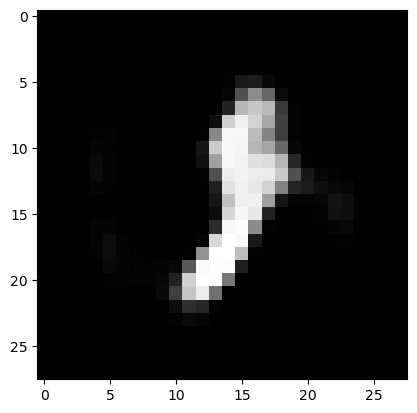

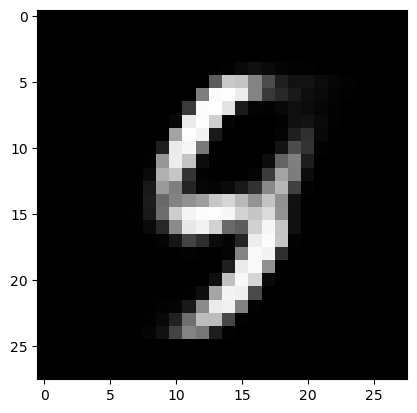

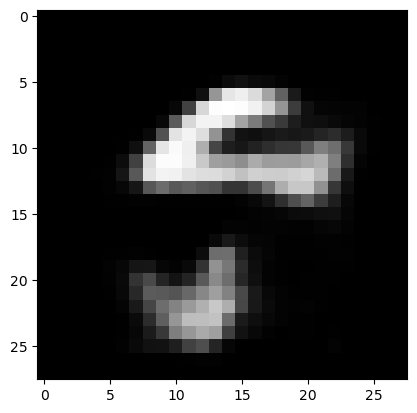

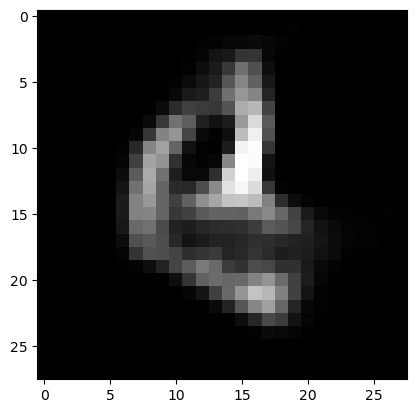

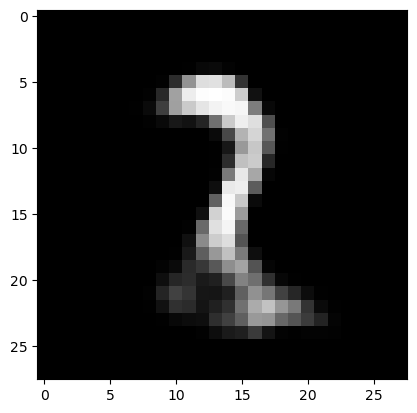

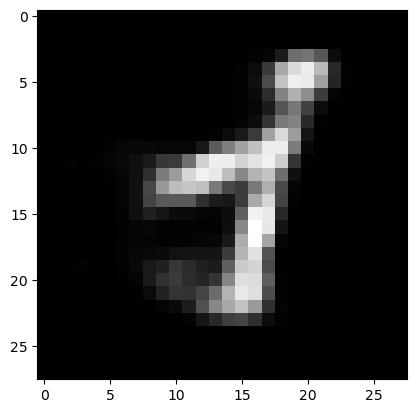

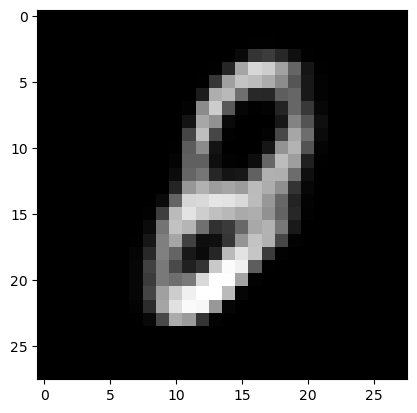

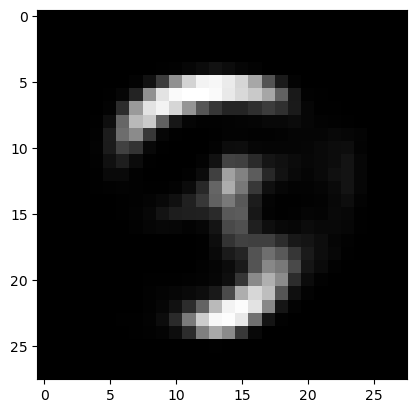

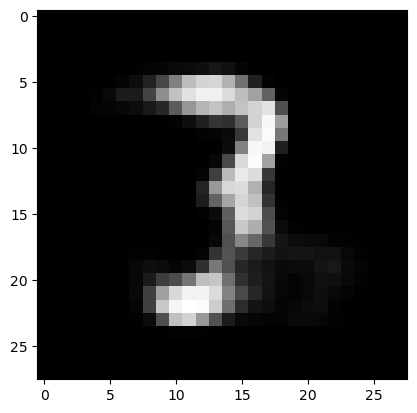

In [ ]:
# sample and generate a image
for i in range(10):
    z = torch.randn(1, LATENT_DIM).to(device)
    reconstructed_img = model.dec(z)
    img = reconstructed_img.cpu().view(28, 28).data

    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.show()

# Reference

https://github.com/graviraja/pytorch-sample-codes/blob/master/simple_vae.py

https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/generative_adversarial_network/main.py